# AUDIO

In [16]:
import torch
import torchaudio


print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2.1.1+cu118
2.1.1+cu118
cuda


In [17]:
waveform, sample_rate = torchaudio.load("audio\wav\Bombus_Hortorum [3jMhCZytLEk]-1.wav")



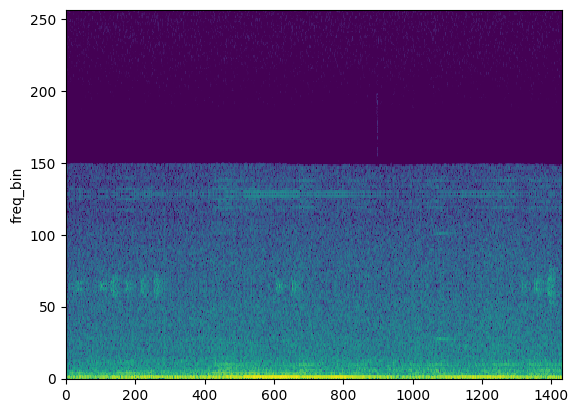

In [18]:
import librosa
import matplotlib.pyplot as plt
from torchaudio.transforms import Spectrogram
spectogram = Spectrogram(n_fft=512)
spec = spectogram(waveform)
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

plot_spectrogram(spec[0])


In [19]:
waveform.to(device=torch.device("cuda"), dtype=torch.float32)

tensor([[-0.0143, -0.0168, -0.0163,  ..., -0.0013, -0.0034, -0.0026],
        [-0.0143, -0.0169, -0.0163,  ..., -0.0013, -0.0034, -0.0027]],
       device='cuda:0')

In [20]:
from torchaudio.transforms import *

class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=8000,
        n_fft=1024,
        n_mel=256,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.resample = Resample(orig_freq=input_freq, new_freq=resample_freq)

        self.spec = Spectrogram(n_fft=n_fft, power=2)

        self.spec_aug = torch.nn.Sequential(
            TimeStretch(stretch_factor, fixed_rate=True),
            FrequencyMasking(freq_mask_param=80),
            TimeMasking(time_mask_param=80),
        )

        self.mel_scale = MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        # Resample the input
        resampled = self.resample(waveform)

        # Convert to power spectrogram
        spec = self.spec(resampled)

        # Apply SpecAugment
        spec = self.spec_aug(spec)

        # Convert to mel-scale
        mel = self.mel_scale(spec)

        return mel
    
# Instantiate a pipeline
pipeline = MyPipeline()

# Move the computation graph to CUDA
pipeline.to(device=torch.device("cuda"), dtype=torch.float32)
waveform = waveform.to(device=torch.device("cuda"), dtype=torch.float32)

# Perform the transform
features = pipeline(waveform)

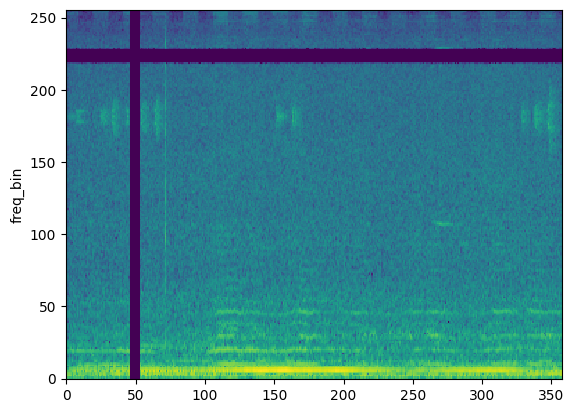

In [21]:
plot_spectrogram(features[0].cpu().numpy()) # features

In [22]:
import pywt
import numpy as np

wavelets = pywt.cwt(waveform[0].numpy(), wavelet="morl", scales=pywt.frequency2scale('morl', np.array([2000, 1500, 1000, 750, 500, 200])/1000), sampling_period=0.001)
fig, ax = plt.subplots(1,1)
im = ax.imshow(wavelets[0], interpolation='nearest', aspect='auto', origin='lower')
plt.colorbar(im)
plt.yticks(np.arange(wavelets[0].shape[0])[::-1],np.round(wavelets[1],3))
plt.xlabel('Inline No.')
plt.ylabel('Wavelet Frequencys')
plt.show()


ModuleNotFoundError: No module named 'pywt'

In [ ]:
pywt.frequency2scale('morl', np.array([1000, 500, 200, 100, 50, 25, 10, 5, 2])/100)

array([ 0.08125,  0.1625 ,  0.40625,  0.8125 ,  1.625  ,  3.25   ,
        8.125  , 16.25   , 40.625  ])

In [23]:
waveform[0].numpy()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [25]:
import torch
from noisereduce.torchgate import TorchGate as TG
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tg = TG(sr=8000, nonstationary=True).to(device)

noisy = waveform
clean = tg(noisy)

print(clean)

tensor([[-0.0027, -0.0012, -0.0010,  ..., -0.0049, -0.0037, -0.0027],
        [-0.0026, -0.0013, -0.0010,  ..., -0.0049, -0.0037, -0.0027]],
       device='cuda:0')


# DATE & LOCATION IMPORT

In [1]:
import pandas as pd

inaturalist_bombus_observations = pd.read_csv("observations-386953.csv")

inaturalist_bombus_observations.head()

,id,observed_on_string,observed_on,time_observed_at,time_zone,user_id,user_login,user_name,created_at,updated_at,...,geoprivacy,taxon_geoprivacy,coordinates_obscured,positioning_method,positioning_device,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,6102,2010-03-17,2010-03-17,NaN,UTC,160,tiggrx,Tig,2010-03-20 06:46:39 +0000,2023-07-17 03:20:37 +0000,...,NaN,NaN,False,NaN,NaN,Large Red-tailed Bumblebee,Bombus lapidarius,Red-tailed Bumble Bee,Insecta,57619
1,6208,2009-03-16,2009-03-16,NaN,UTC,160,tiggrx,Tig,2010-03-24 19:55:17 +0000,2021-04-09 08:21:21 +0000,...,NaN,NaN,False,NaN,NaN,Buff-tailed Bumblebee,Bombus terrestris,Buff-tailed Bumble Bee,Insecta,57516
2,61525,2012-04-01,2012-04-01,NaN,London,4989,acljohn,NaN,2012-04-01 13:59:16 +0000,2021-04-09 08:21:12 +0000,...,NaN,NaN,False,NaN,NaN,Buff-tailed Bumble Bee,Bombus terrestris,Buff-tailed Bumble Bee,Insecta,57516
3,111929,2012-06-04,2012-06-04,NaN,Europe/London,4989,acljohn,NaN,2012-08-12 15:01:28 +0000,2019-09-18 09:52:40 +0000,...,NaN,NaN,False,NaN,NaN,Bumble Bees,Bombus,Bumble Bees,Insecta,52775
4,188227,"August 26, 2012",2012-08-26,NaN,Eastern Time (US & Canada),11758,jaderr,Rebecca Rissanen,2013-01-29 15:40:00 +0000,2020-06-09 11:59:58 +0000,...,NaN,NaN,False,NaN,NaN,Buff-tailed Bumble Bee,Bombus terrestris,Buff-tailed Bumble Bee,Insecta,57516


In [ ]:
inaturalist_bombus_observations.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'user_name', 'created_at',
       'updated_at', 'quality_grade', 'license', 'url', 'image_url',
       'sound_url', 'tag_list', 'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'private_place_guess', 'private_latitude',
       'private_longitude', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'positioning_method',
       'positioning_device', 'species_guess', 'scientific_name', 'common_name',
       'iconic_taxon_name', 'taxon_id'],
      dtype='object')

In [43]:
bombus_df = inaturalist_bombus_observations.copy()

bombus_df = bombus_df[['id', 'latitude', 'longitude', 'scientific_name', 'observed_on']]



In [ ]:
print(len(bombus_df['scientific_name'].value_counts()))

25


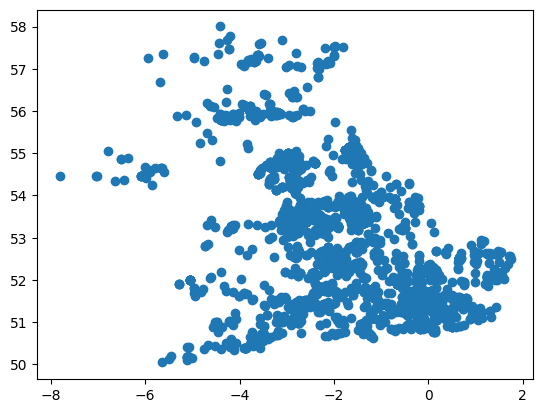

In [ ]:
bombus_pratorum = bombus_df[bombus_df['scientific_name'] == 'Bombus pratorum']

import matplotlib.pyplot as plt

plt.scatter(bombus_pratorum['longitude'], bombus_pratorum['latitude'])
plt.show()


# Preprocessing

In [44]:
# limit scope

top = bombus_df['scientific_name'].value_counts()[:5].index
bombus_df = bombus_df[bombus_df['scientific_name'].isin(top)]

In [45]:
# Date encoding
import numpy as np

def cyclic_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    return df


bombus_df['observed_on'] = pd.to_datetime(bombus_df['observed_on'])
bombus_df['observed_on'] = bombus_df['observed_on'].dt.dayofyear

bombus_df = cyclic_encode(bombus_df, 'observed_on', 365)

In [46]:
# Location encoding

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
bombus_df['longitude'] = min_max_scaler.fit_transform(bombus_df[['longitude']])
bombus_df['latitude'] = min_max_scaler.fit_transform(bombus_df[['latitude']])

# scale date

# bombus_df['observed_on_cos'] = min_max_scaler.fit_transform(bombus_df[['observed_on_cos']])
# bombus_df['observed_on_sin'] = min_max_scaler.fit_transform(bombus_df[['observed_on_sin']])

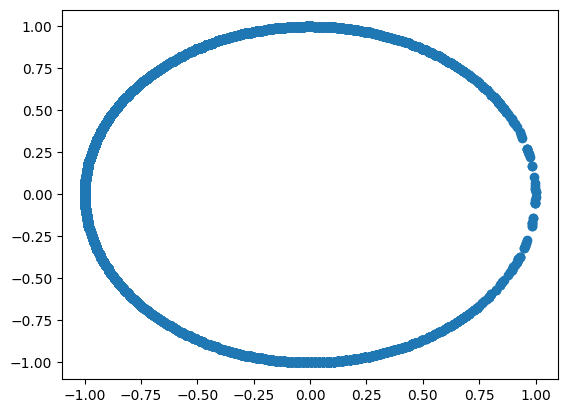

In [47]:
import matplotlib.pyplot as plt

plt.scatter(bombus_df['observed_on_cos'], bombus_df['observed_on_sin'])

In [48]:
bombus_df['observed_on'].min()

1

In [49]:
from sklearn import model_selection

train, test = model_selection.train_test_split(bombus_df, test_size=0.3)

x_train = train[['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin']]
y_train = train[['scientific_name']]
x_test = test[['longitude', 'latitude', 'observed_on_cos', 'observed_on_sin']]
y_test = test[['scientific_name']]

print(y_test.value_counts())

scientific_name  
Bombus pascuorum     2138
Bombus terrestris    1293
Bombus hypnorum      1200
Bombus lapidarius    1133
Bombus pratorum       707
Name: count, dtype: int64


In [50]:
import imblearn

ros = imblearn.over_sampling.RandomOverSampler()
x_train, y_train = ros.fit_resample(x_train, y_train)

In [51]:
print(y_train.value_counts())

scientific_name  
Bombus hypnorum      4961
Bombus lapidarius    4961
Bombus pascuorum     4961
Bombus pratorum      4961
Bombus terrestris    4961
Name: count, dtype: int64


# Method Tests

In [52]:
# KNN

from sklearn import neighbors
import numpy as np
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train, np.ravel(y_train))

knn.score(x_test, np.ravel(y_test))

0.3286972647195178

In [53]:
# Logistic Regression

from sklearn import linear_model

lr = linear_model.LogisticRegression(max_iter=1000)
lr.fit(x_train, np.ravel(y_train))

lr.score(x_test, np.ravel(y_test))



0.3616133518776078

In [54]:
# SVM

from sklearn import svm

svm = svm.SVC()
svm.fit(x_train, np.ravel(y_train))

svm.score(x_test, np.ravel(y_test))

0.42342760006181424

In [57]:
# Random Forest

from sklearn import ensemble

rf = ensemble.RandomForestClassifier()
rf.fit(x_train, np.ravel(y_train))

rf.score(x_test, np.ravel(y_test))

0.3767578426827384

In [61]:
# Calibrated Classifier

from sklearn import calibration

cc = calibration.CalibratedClassifierCV(svm)
cc.fit(x_train, np.ravel(y_train))
y_proba = cc.predict_proba(x_test)

In [62]:
cc.score(x_test, np.ravel(y_test))

0.42141863699582754

In [58]:
# metrics

from sklearn import metrics

class_names = list(y_test['scientific_name'].value_counts().index)

cm = metrics.confusion_matrix(np.ravel(y_test), np.ravel(rf.predict(x_test)), normalize='true')

# We will store the results in a dictionary for easy access later
per_class_accuracies = {}

# Calculate the accuracy for each one of our classes
for idx, cls in enumerate(class_names):
    # True negatives are all the samples that are not our current GT class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is the ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)

['Bombus pascuorum', 'Bombus terrestris', 'Bombus hypnorum', 'Bombus lapidarius', 'Bombus pratorum']
[0.4191666666666667, 0.3115622241835834, 0.4695977549111319, 0.2743988684582744, 0.29698375870069604]


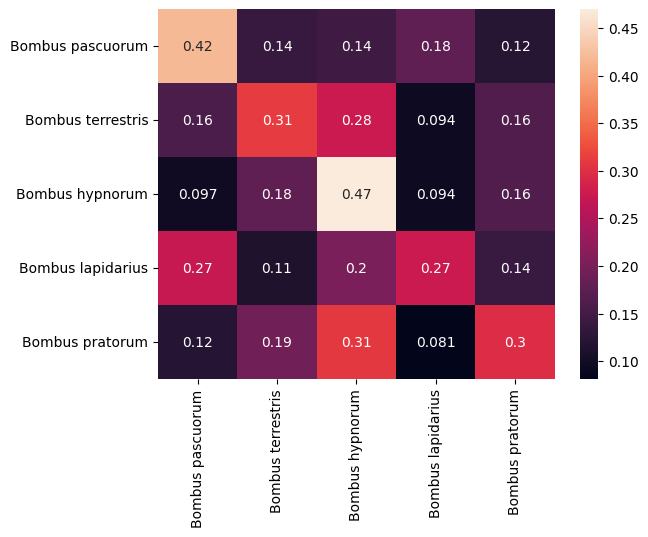

In [59]:
import seaborn as sns

class_names = list(y_test['scientific_name'].value_counts().index)

sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)

corr = [cm[i, i] / np.sum(cm[i, :]) for i in range(len(class_names))]

print(class_names)
print(corr)
    

In [60]:
svm.support_vectors_

array([[ 0.75457294,  0.35894679, -0.79877937,  0.60162406],
       [ 0.58901332,  0.33530818, -0.93228921,  0.36171373],
       [ 0.55446408,  0.15312354, -0.81901489,  0.57377227],
       ...,
       [ 0.48166771,  0.4618731 , -0.63210341, -0.77488404],
       [ 0.95885182,  0.14566793, -0.89774339,  0.44051878],
       [ 0.65938655,  0.47484955, -0.856551  , -0.51606239]])